In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

**NOTE:** Some words I use exchangeably with one another:
* field/variable
* independent/input (e.g. independent variables, input variables)

# 1. Getting to know the Ames Housing Dataset
a modern, more challenging alternative to the well-known Boston Housing dataset

In [2]:
train_df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

print('Train set: %d observations, %d features' % (train_df.shape[0], train_df.shape[1]))
print('Test set: %d observations, %d features' % (test_df.shape[0], test_df.shape[1]))


Train set: 1460 observations, 81 features
Test set: 1459 observations, 80 features


As you can see, the **Ames Housing dataset** comprises of **79** (not counting the **id** field in the train set!) independent variables and **1 target variable**. For a description of each input variable, please see the data_description.txt included in the dataset.

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 1.1 The target variable at a glance
Let's take a look at our target variable, "SalePrice" which is the house selling price in dollars:

In [5]:
target_variable = 'SalePrice'
train_df[target_variable].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

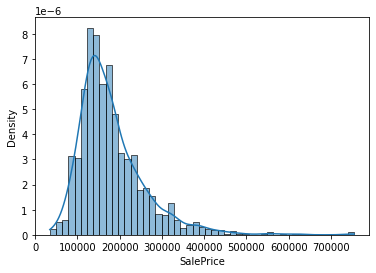

In [6]:
sns.histplot(train_df[target_variable], stat='density', kde=True)

The histogram above shows that the distribution looks like a normal distribution but one that it's skewed to the right.

We'll go more in depth with this later on in this notebook.

## 1.2 Input Variables at a Glance
In the next section, let's explore the variables with the eventual goal of feature selection (i.e. deciding which variables to use) and feature engineering (i.e. generating new features) for predicting house pricing.

Let's see first how much of our fields are numerical or categorical.

,count
int64,35
float64,3
object,43


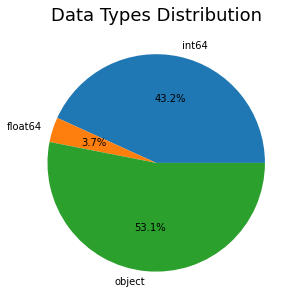

In [7]:
dtypes, counts = np.unique(train_df.dtypes.values, return_counts=True)
dtypes_df = pd.DataFrame(data={'count':counts}, index=dtypes)
ax = dtypes_df.plot.pie(y='count', figsize=(5,5), legend=False, autopct='%1.1f%%')
ax.set_ylabel('')
ax.set_title('Data Types Distribution', fontsize=18);
dtypes_df.head()

More than half of (43) our independent variables are categorical, while the rest (36) are numerical. Let's display those variable names real quick:

In [8]:
numerical_fields = [f for f in train_df.columns if (train_df.dtypes[f] != 'object' and f not in ['Id', 'SalePrice'])]
len(numerical_fields), numerical_fields

(36,
 ['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold'])

In [9]:
categorical_fields = [f for f in train_df.columns if (train_df.dtypes[f] == 'object' and f not in ['Id', 'SalePrice'])]
len(categorical_fields), categorical_fields

(43,
 ['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Heating',
  'HeatingQC',
  'CentralAir',
  'Electrical',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PavedDrive',
  'PoolQC',
  'Fence',
  'MiscFeature',
  'SaleType',
  'SaleCondition'])

## 1.3 Missing Data?
Let's check next whether there are missing data (i.e. NULL, None, or NaN entries) in our dataset or not. Important questions that need to be raised regarding missing data include:
* How much of our data have missing data?
 * *If we simply remove entries with missing data, we might end up with too little data to make an analysis with*
* Is there a pattern to the blanks in our data or is it just random?

Let's check on a per-field basis to check if we can simply drop fields/variables that have a significant amount of missing data. And if all else fails, we may have to delete some instances/observations if there are only a few instances missing from a field.

### 1.3.1 Missing Data in the Train Set

<AxesSubplot:>

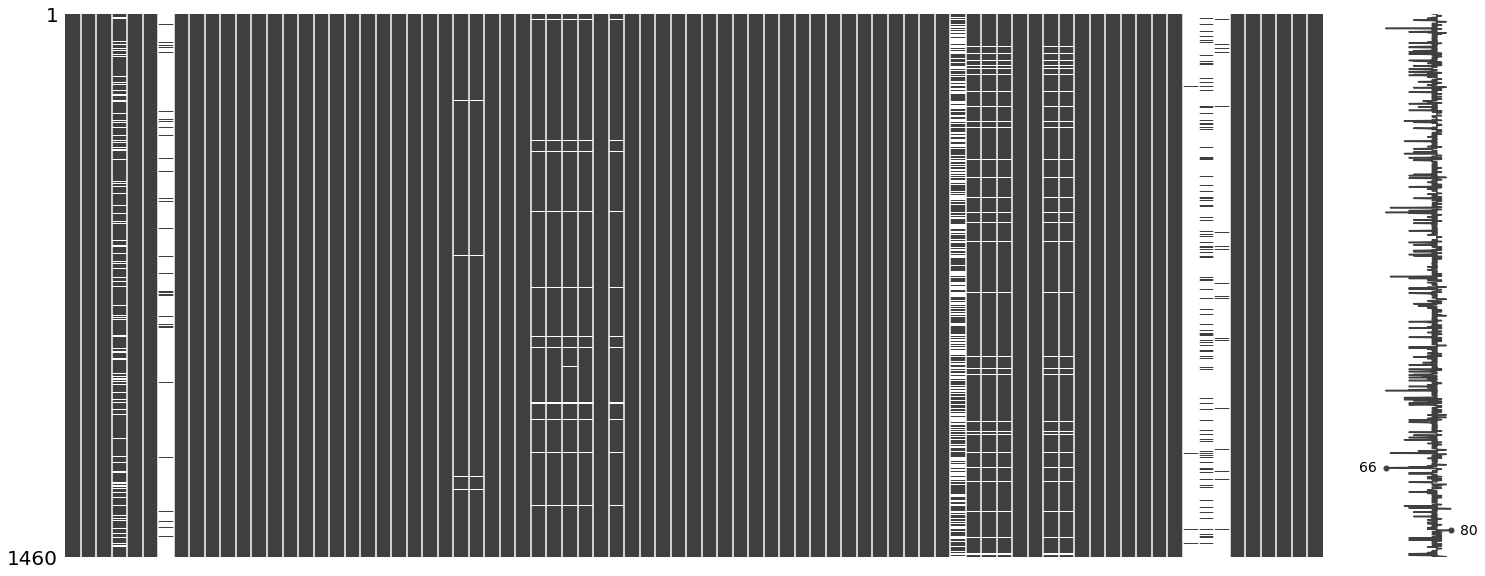

In [10]:
msno.matrix(train_df)

In [11]:
# Define a function for obtaining a dataframe containing the missing data
def get_missing_data(input_df):
    missing_count = input_df.isnull().sum().sort_values(ascending=False)
    missing_count = missing_count[missing_count.values>0]
    percents = ((input_df.isnull().sum()/input_df.isnull().count())).sort_values(ascending=False)
    percents = percents[percents.values>0]
    missing_data = pd.concat([missing_count, percents], axis=1, keys=['total_num', '%'])
    return missing_data

In [12]:
missing_train_data = get_missing_data(train_df)
missing_train_data.head(missing_train_data.shape[0])

,total_num,%
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


### 1.3.2. Missing Data in the Test Set

<AxesSubplot:>

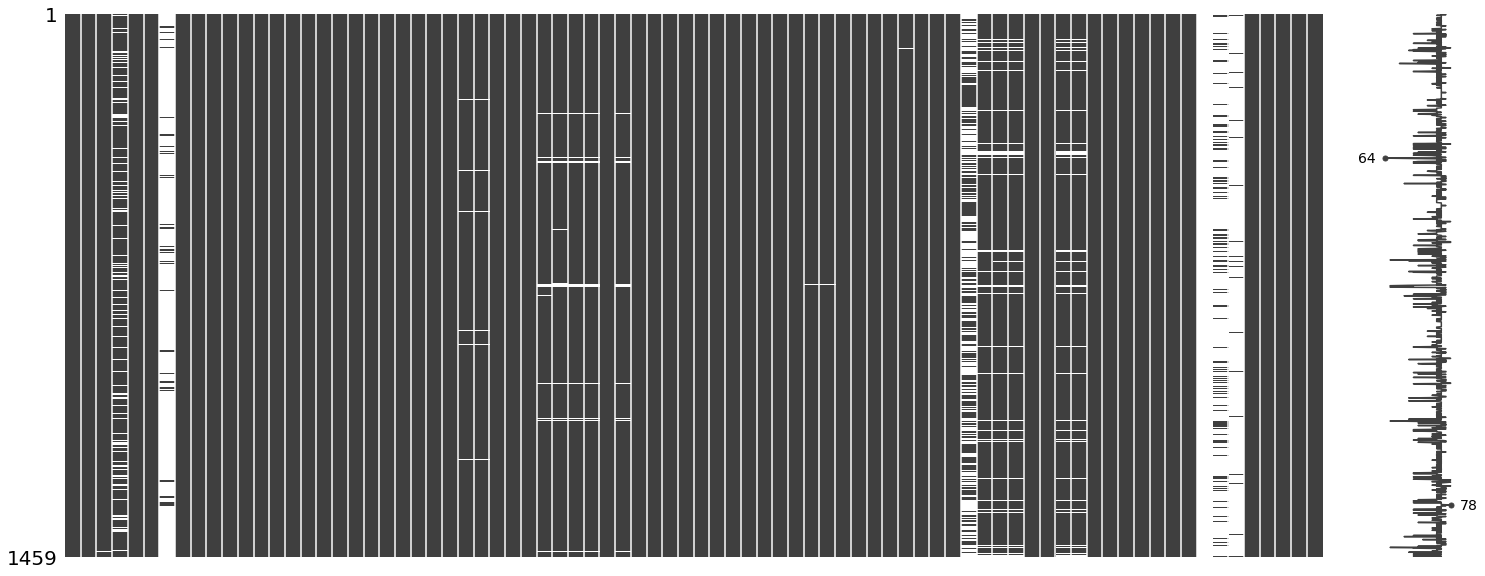

In [13]:
msno.matrix(test_df)

In [14]:
missing_test_data = get_missing_data(test_df)
missing_test_data.head(missing_test_data.shape[0])

,total_num,%
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


As can be seen in the two tables above, we have a few fields with missing data to deal with! Let's look into this in the next section whether we can drop them, or create alternative features from them instead.

# 2. Exploratory Data Analysis

## 2.1 Key Assumptions for Linear Multivariate Regression
But before that, we inevatibly have to discuss some assumptions necessary for most linear multivariate regression techniques:


## 2.2 The Target Variable: SalePrice
Let's take a look at the star of this show: SalePrice! We've taken a quick glimpse of it in the previous section, but now let's dive deep into it.

First, let's try see if its distribution conforms with a normal distribution with its histogram plot and its Q-Q plot.

*HINT: A quantile-quantile plot checks whether two sets of data has the same distribution. If the scatter plot conforms to the line, then they pretty much have the same distribution!*

In [15]:
#Define a function for plotting the distplot and QQ plot because code reuse is awesome!
def plot_normality_check(field, dataframe, figsize=(10,5)):
    f, ax = plt.subplots(1,2, figsize=figsize)
    sns.distplot(dataframe[field], fit=norm, ax=ax[0])
    ax[0].set_title('{} distribution'.format(field))
    
    stats.probplot(dataframe[field], plot=ax[1]);

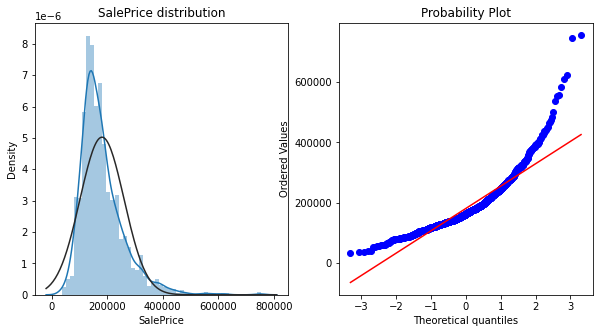

In [16]:
plot_normality_check(field=target_variable, dataframe=train_df)

The histogram plot shows something like a gaussian bell curve but skewed to the right.

Numerically, the distribution's asymmetry can be described by **Skewness** (positive means skewed to the right) and **Kurtosis** (bigger positive means "heavy-tailed"):

In [17]:
print("Skewness: %f" % (train_df['SalePrice'].skew()))
print("Kurtosis: %f" % (train_df['SalePrice'].kurt()))

Skewness: 1.882876
Kurtosis: 6.536282


Additionally, the scatter plot deviates heavily from the line, i.e. our target variable **SalePrice** is not normally distributed!

This can easily be solved by doing a log transformation of **SalePrice**, which we do now, and subsequently check the plot again:

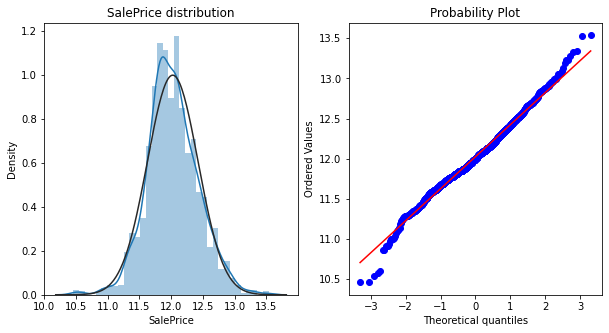

In [18]:
#log transformation
train_df[target_variable] = np.log1p(train_df[target_variable])

plot_normality_check(field=target_variable, dataframe=train_df)

## 2.3 Feature Importances
Let's compute the feature importances for all input features/variables and plot them side by side in a comprehensive bar graph!

*Note that we have to do 2 things to our categorical field values beforehand:*
* replace NA or invalid values
* perform some encoding (e.g. one-hot encoding)

In [19]:
tmp_df = train_df.copy()
tmp_df[categorical_fields] = tmp_df[categorical_fields].fillna('NULL')

for field in categorical_fields:
    le = LabelEncoder()
    le.fit(tmp_df[field])
    tmp_df[field] = le.transform(tmp_df[field])

Afterwards, let's use Microsoft's [Light Gradient Boosting Machine (LGBM)](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html?highlight=gbm.feature_importance#lightgbm.Booster.feature_importance) library to compute for the feature importances:

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3391
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 74
[LightGBM] [Info] Start training from score 12.024057


C:\Users\Jessa\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


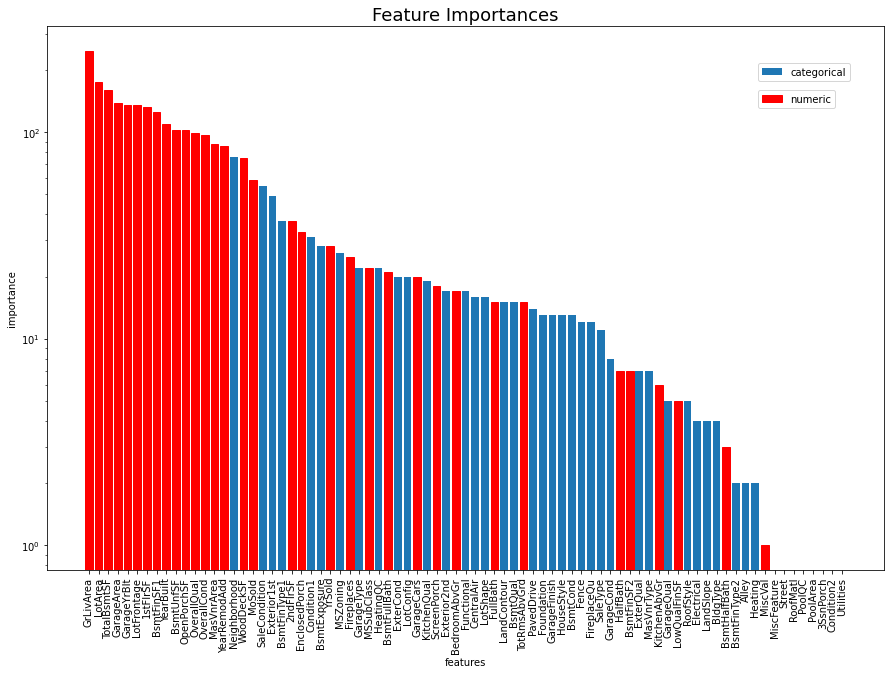

In [20]:
#Setup the GBM with our train dataset
X_train = tmp_df.drop([target_variable, 'Id'], axis=1)
y_train = tmp_df[target_variable]
lgb_train = lgb.Dataset(data=X_train, label=y_train)
gbm = lgb.train(params={'objective':'regression', 'metric':'rmse'}, train_set=lgb_train)

#Create a dataframe for easy plotting:
#We are using the 'split' importance_type here. Alternative type is the 'gain'. More info on the LGBM docs.
feature_importances = pd.DataFrame({'importance':gbm.feature_importance(importance_type='split')}, index=X_train.columns)
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances['dtype'] = ['numeric' if field in numerical_fields else 'categorical' for field in feature_importances.index]

#Prepare stuff for plotting
fig, ax = plt.subplots(figsize=(15,10))

#Make the plot prettier and more readable:
ax.set_xticklabels(feature_importances.index, rotation=90)
ax.set_xlabel('features')
ax.set_ylabel('importance')
ax.set_title('Feature Importances', fontsize=18)
ax.set_yscale('log') #Set y scale to log because of big difference between largest and smallest bars

#Plot the bar graph and set the legend for "categorical" fields
bars = ax.bar(feature_importances.index, feature_importances['importance'])
legend_cat = ax.legend(['categorical'], loc=(0.85, 0.9))
fig.gca().add_artist(legend_cat)

#Change the color of the bars for "numerical" fields and show the legend for them
for i in np.where(feature_importances['dtype'].values=='numeric')[0]:
    bars[i].set_color('red')
legend_num = ax.legend(['numeric'], loc=(0.85, 0.85))

The y-axis shows the importance of each feature, measured by the chosen importance_type metric (here we use *'split'*). We can see that the top features are mostly numerical ones, with **GrLivArea** taking the lead.

## 2.4 Numerical Fields

### 2.4.1 Univariate Analysis
Next thing we want to look at are the distributions of the numerical fields. Summon the histograms!

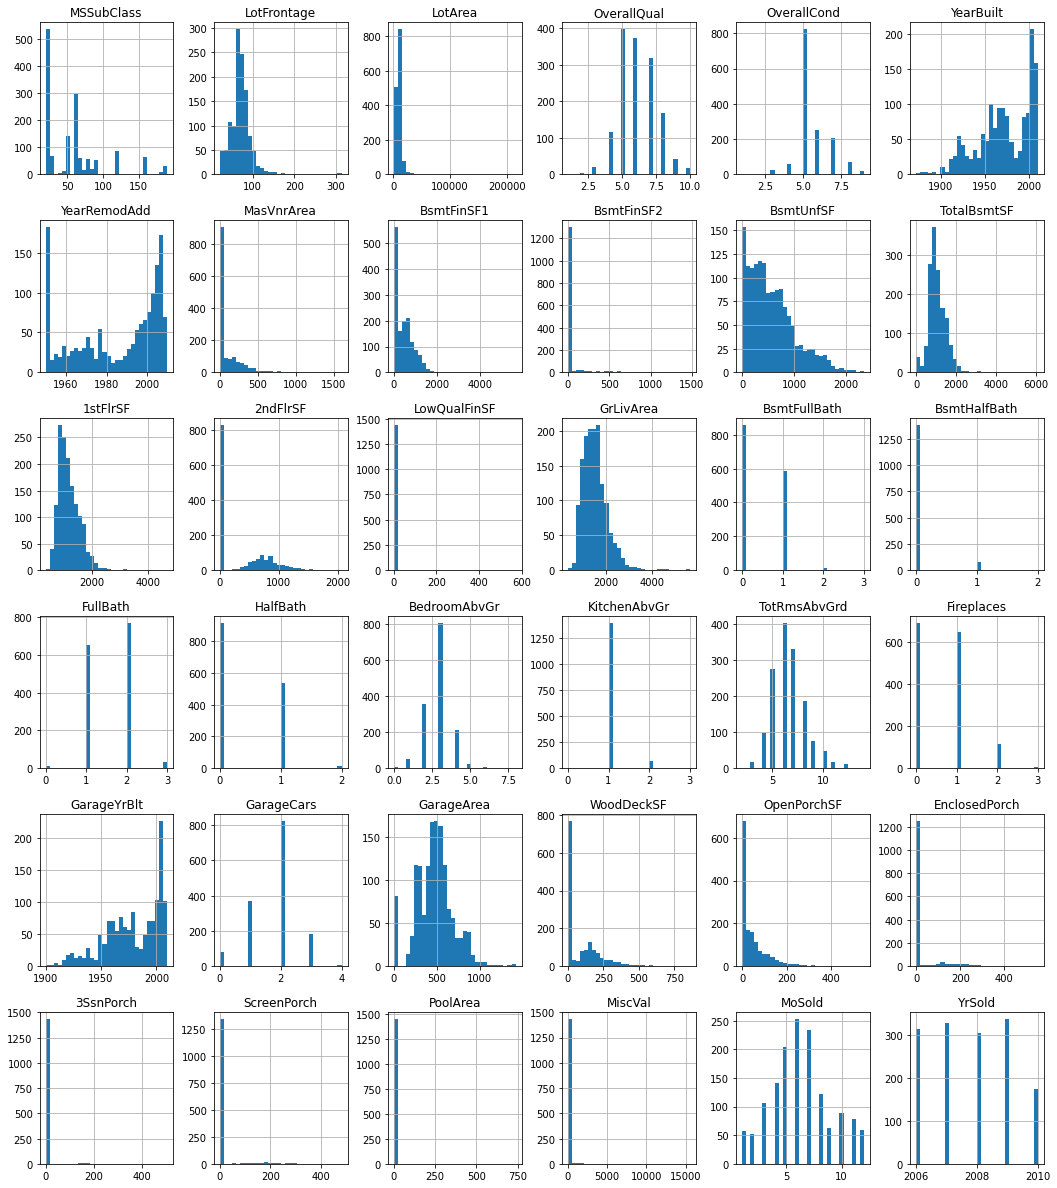

In [21]:
train_df[numerical_fields].hist(figsize=(18,21), bins=30);

### 2.4.2 Correlation matrix
Another quick way to get an overview of the features available is the correlation matrix.
Quick and dirty way of interpreting the correlation matrix:
* high positive correlation => likely **directly proportional**
* high negative correlation => likely **indirectly proportional**
* near 0 correlation between 2 variables means no relation

How about let's paint the big picture and plot the correlation matrix as a heat map for *all* numerical fields? Here we're using *Spearman Correlation* to measure the monotonic component of the relationship between variables (as compared to the default *Pearson*  correlation which focuses more on the linear relationship).

In [22]:
def get_corr_matrix(input_df, method='spearman', sort_by=None):
    corr_matrix = (input_df).corr(method=method)
    if sort_by is not None:
        cols = corr_matrix.sort_values(by=sort_by, ascending=False).index
        corr_matrix = corr_matrix.loc[cols, cols]
    return corr_matrix, cols

<AxesSubplot:>

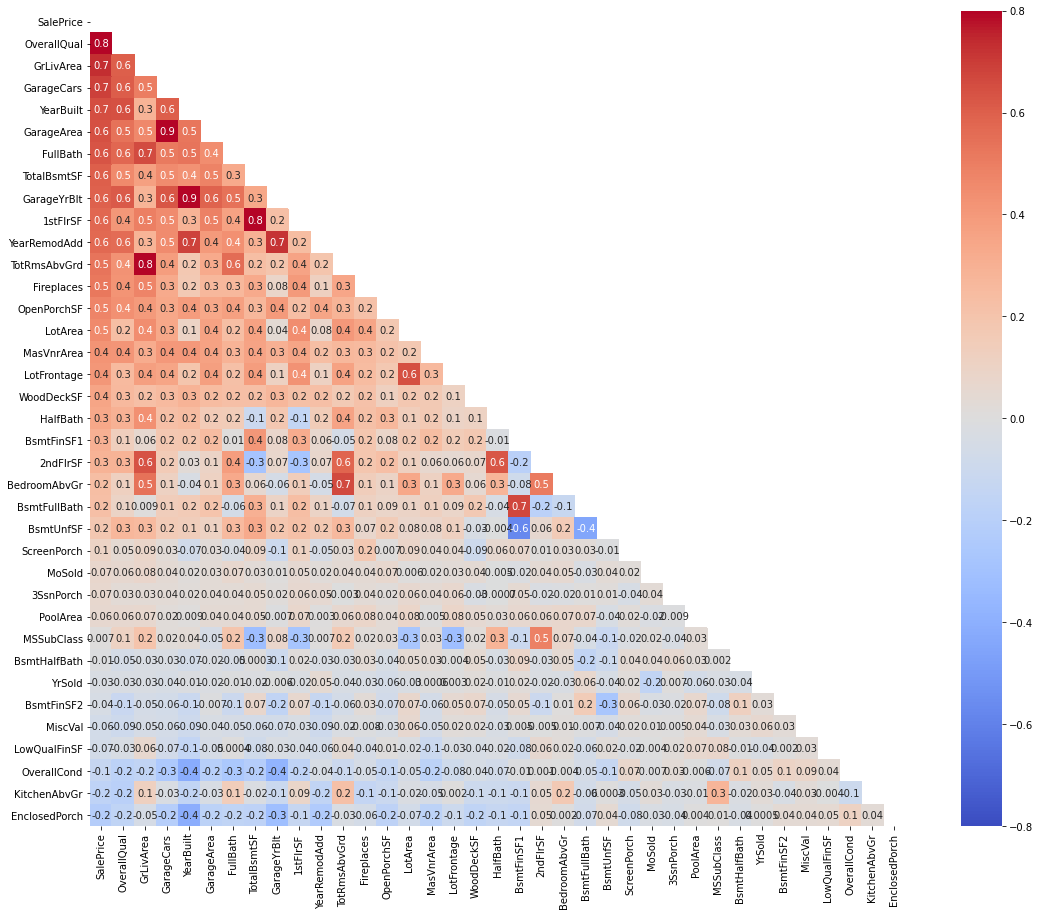

In [23]:
corr_matrix, cols = get_corr_matrix(train_df[numerical_fields + [target_variable]], sort_by=target_variable)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, square=True, mask=mask, vmax=0.8, vmin=-0.8, center=0.0, annot=True, fmt='.1g', cmap='coolwarm')

The heatmap above is ordered by the target variable **SalePrice** on the left-most column. We can see that the reds are nicely concentrated on the top while the not-so-red ones at the bottom.

Observations:

Highly-correlated input fields(>0.8; higher corr with SalePrice, in **bold face**):
 * **GarageCars** and GarageArea: the more cars you can fit in your garage, the higher the garage area, right? Maybe we can drop one.
 * **YearBuilt**, GarageYrBlt, YearRemodAdd: Seems garages are mostly built at the same time as the house itself. Maybe we can introduce a new feature called *'HasGarage'* instead and remove GarageYrBlt? Also, most houses in the dataset have NOT been remodeled (i.e. YearRemodAdd is same as YearBuilt), so we'll decide to drop the YearRemodAdd column.
 
Slightly-correlated(0.7-0.799) with each other:
 * **TotalBsmtSF** and 1stFlrSF: drop?
 * **GrLivArea** and TotRmsAbvGrd: drop?
 * **TotRmsAbvGrd** and BedrAbvGrd
 * **BsmtFullBath** and BsmtFinSF1
 
 The fields with the highest-correlation with **SalePrice**:
 * **OverallQual**: a somewhat obvious predictor for **SalePrice**. 
 * **GrLivArea**: Living are
 * **GarageCars**:
 * **YearBuilt**
 * **FullBath**

### 2.4.2 Multivariate Analysis wrt 'SalePrice'
Let's plot all the numerical variables vs. **SalePrice** to see their relationship, shall we?

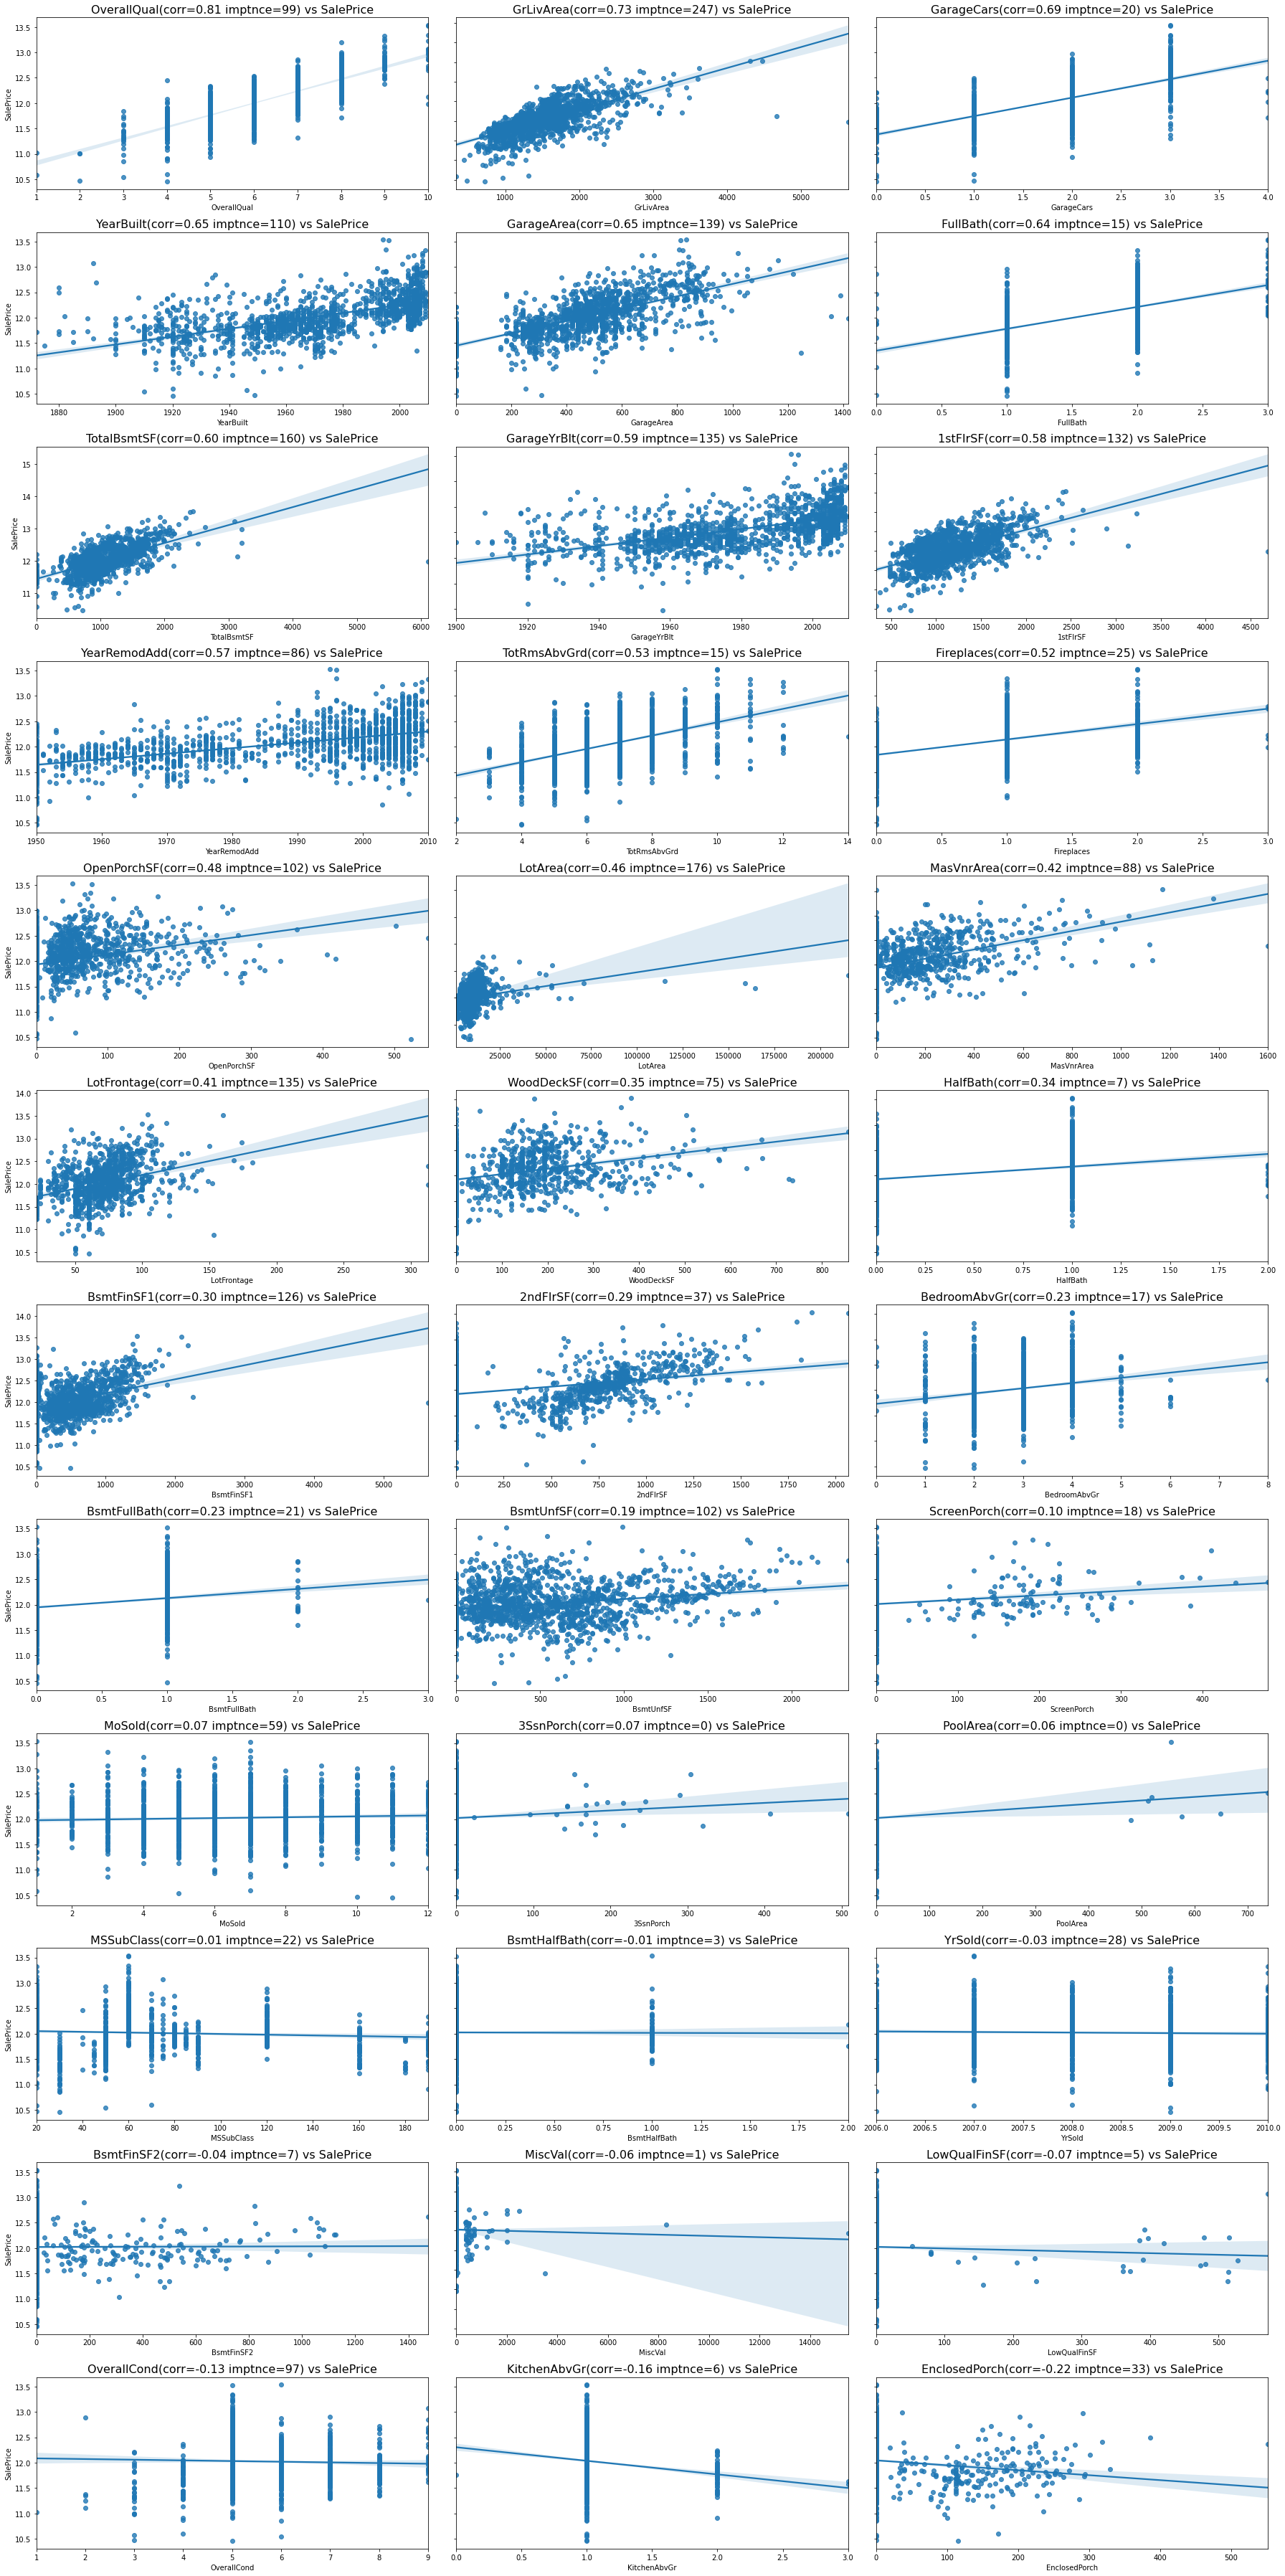

In [24]:
k=len(cols)
top_cols = cols[1:k+1] #skip the 1st one which is 'SalePrice'

num_subplot_columns = 3
num_subplot_rows = k=len(top_cols)//num_subplot_columns + (1 if len(top_cols)%num_subplot_columns>0 else 0)
f, axes = plt.subplots(num_subplot_rows, num_subplot_columns, figsize=(25,50))

for index, field in enumerate(top_cols):
    row = index//num_subplot_columns
    column = index%num_subplot_columns
    current_axis=axes[row][column]
    
    sns.regplot(x=field, y=target_variable, data=train_df, ax=current_axis)
    current_axis.set_title('{}(corr={:1.2f} imptnce={}) vs {}'.format(field, corr_matrix[field][target_variable], feature_importances['importance'][field], target_variable), {'fontsize':16})
    
    if column != 0: # Only show the y-axis labels and ticks on the left-most column!
        current_axis.set_ylabel('')
        current_axis.set_yticklabels('')
f.tight_layout()

Let's look more closely at the relationship between **SalePrice** and **OverallQual**:

Text(0.5, 0.98, 'OverallQual vs. SalePrice')

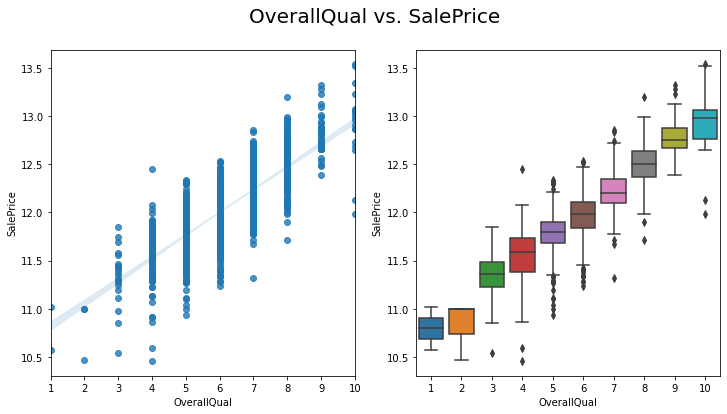

In [25]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
sns.regplot(x='OverallQual', y='SalePrice', data=train_df, ax=ax[0])
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df, ax=ax[1])
f.suptitle('OverallQual vs. SalePrice', fontsize=20)


The boxplot is also shown since OverallQual values are *discrete*, we can see the data clearly per rating. Note the increasing spread over **SalePrice** as the **OverallQual**  rating gets higher. Does this indicate that the **OverallQual** is a subjective metric rather than an objective one?

Let's look at the next field:1

Text(0.5, 1.0, 'GrLivArea vs. SalePrice')

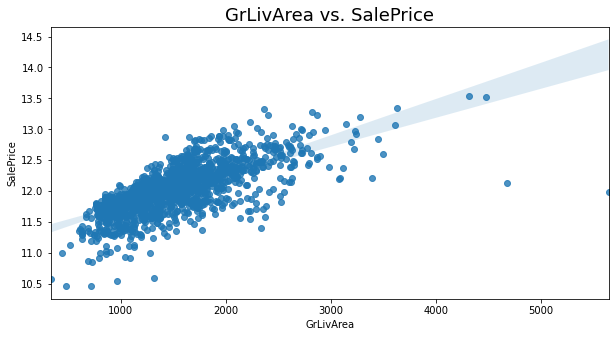

In [26]:
f, ax = plt.subplots(figsize=(10,5))
sns.regplot(x='GrLivArea', y=target_variable, data=train_df, ax=ax)
ax.set_title('GrLivArea vs. SalePrice', fontdict={'fontsize':18})

The two points on the upper right seem to be adhering to the pattern (i.e. the bigger the area, the more expensive it is), so we won't treat them as outliers. Meanwhile there seem tobe two (2) outliers on the lower right. We will get rid of these outliers later on.

Let's look at the next plot:

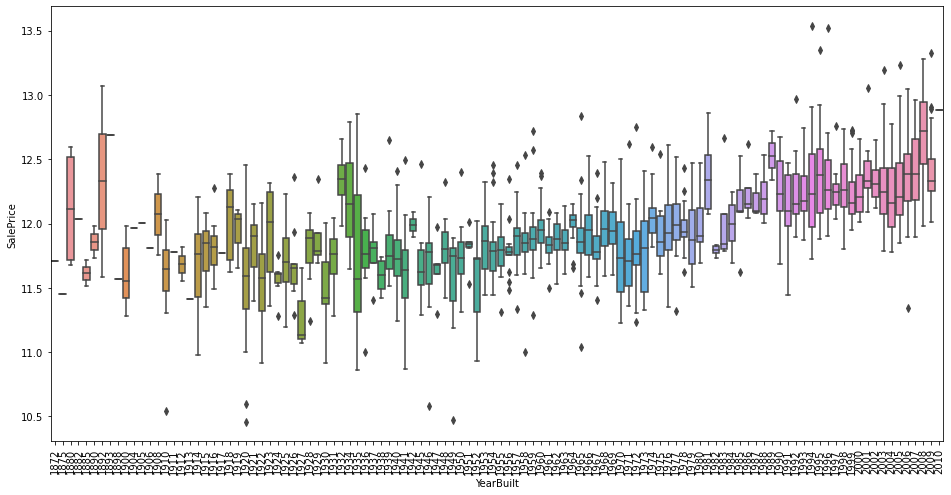

In [27]:
f, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_df)
plt.xticks(rotation=90);

It comes as no surprise that more recently built houses have, in general, higher prices. However we also observe there are relatively old houses that are expensive, perhaps because of their antiquity rather than their quality/structural integrity.

What about the **GarageCars** and **GarageArea**?

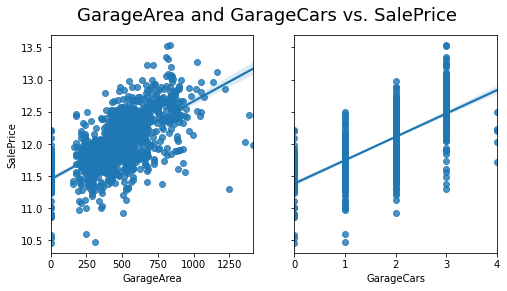

In [28]:
f, ax = plt.subplots(1, 2, figsize=(8,4));

sns.regplot(x='GarageArea', y=target_variable, data=train_df, ax=ax[0]);

sns.regplot(x='GarageCars', y=target_variable, data=train_df, ax=ax[1]);
ax[1].set_ylabel('');
ax[1].set_yticklabels('');

f.suptitle('GarageArea and GarageCars vs. SalePrice', fontsize=18);


Notice there are 4 points on the lower-right side of the plot on the left that seem to be too cheap even if they have a big garage area? I consider those outliers and am inclined to remove them later.
Furthermore, I am inclined to drop the **GarageCars** variable since the information they contain are already in the **GarageArea** field, as previously mentioned. I choose to retain **GarageArea** since it has the higher feature importance rating.

## 2.5 Categorical Fields

### 2.5.1 Univariate Analysis
Let's take a look at the counts per category of all the categorical fields:

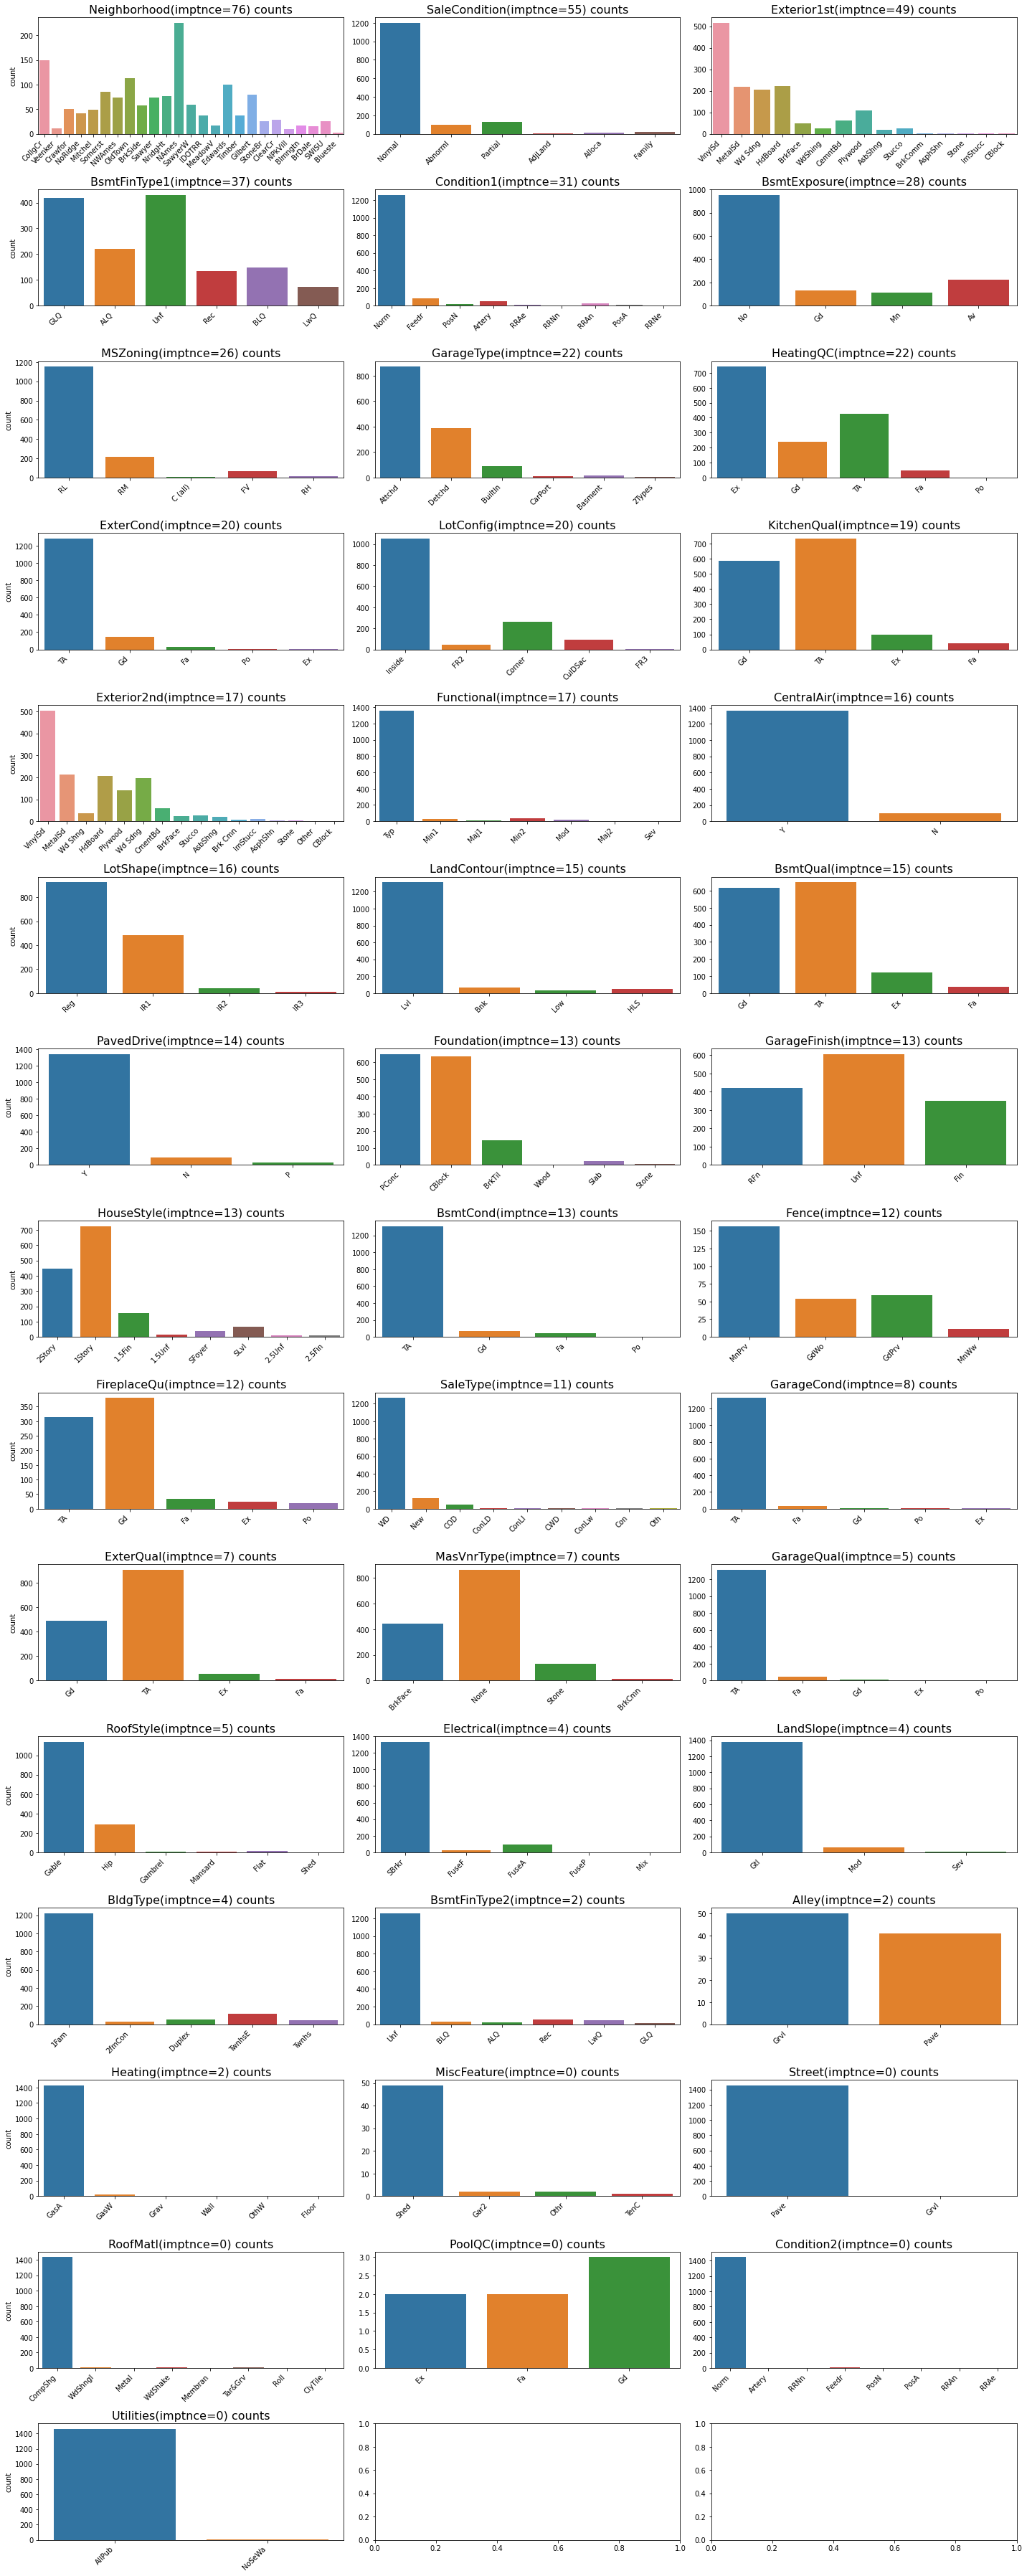

In [29]:
#Arrange the categorical field names according to feature importance
top_cols = [field for field in feature_importances.index if field in categorical_fields]

num_subplot_columns = 3
num_subplot_rows = len(top_cols)//num_subplot_columns + (1 if len(top_cols)%num_subplot_columns>0 else 0)
f, axes = plt.subplots(num_subplot_rows, num_subplot_columns, figsize=(20,50))

for index, field in enumerate(top_cols):
    row = index//num_subplot_columns
    column = index%num_subplot_columns
    current_axis=axes[row][column]
    
    sns.countplot(x=field, data=train_df, ax=current_axis)
    current_axis.set_title('{}(imptnce={}) counts'.format(field, feature_importances['importance'][field]), {'fontsize':16})
    current_axis.set_xticklabels(current_axis.get_xticklabels(), rotation=45, ha='right')
    current_axis.set_xlabel('')

    
    if column != 0: # Only show the y-axis labels and ticks on the left-most column!
        current_axis.set_ylabel('')
f.tight_layout()

## 2.5.2 Multivariate Analysis wrt 'SalePrice'
Next let's go into how the categorical fields are related to the target variable, **SalePrice**.

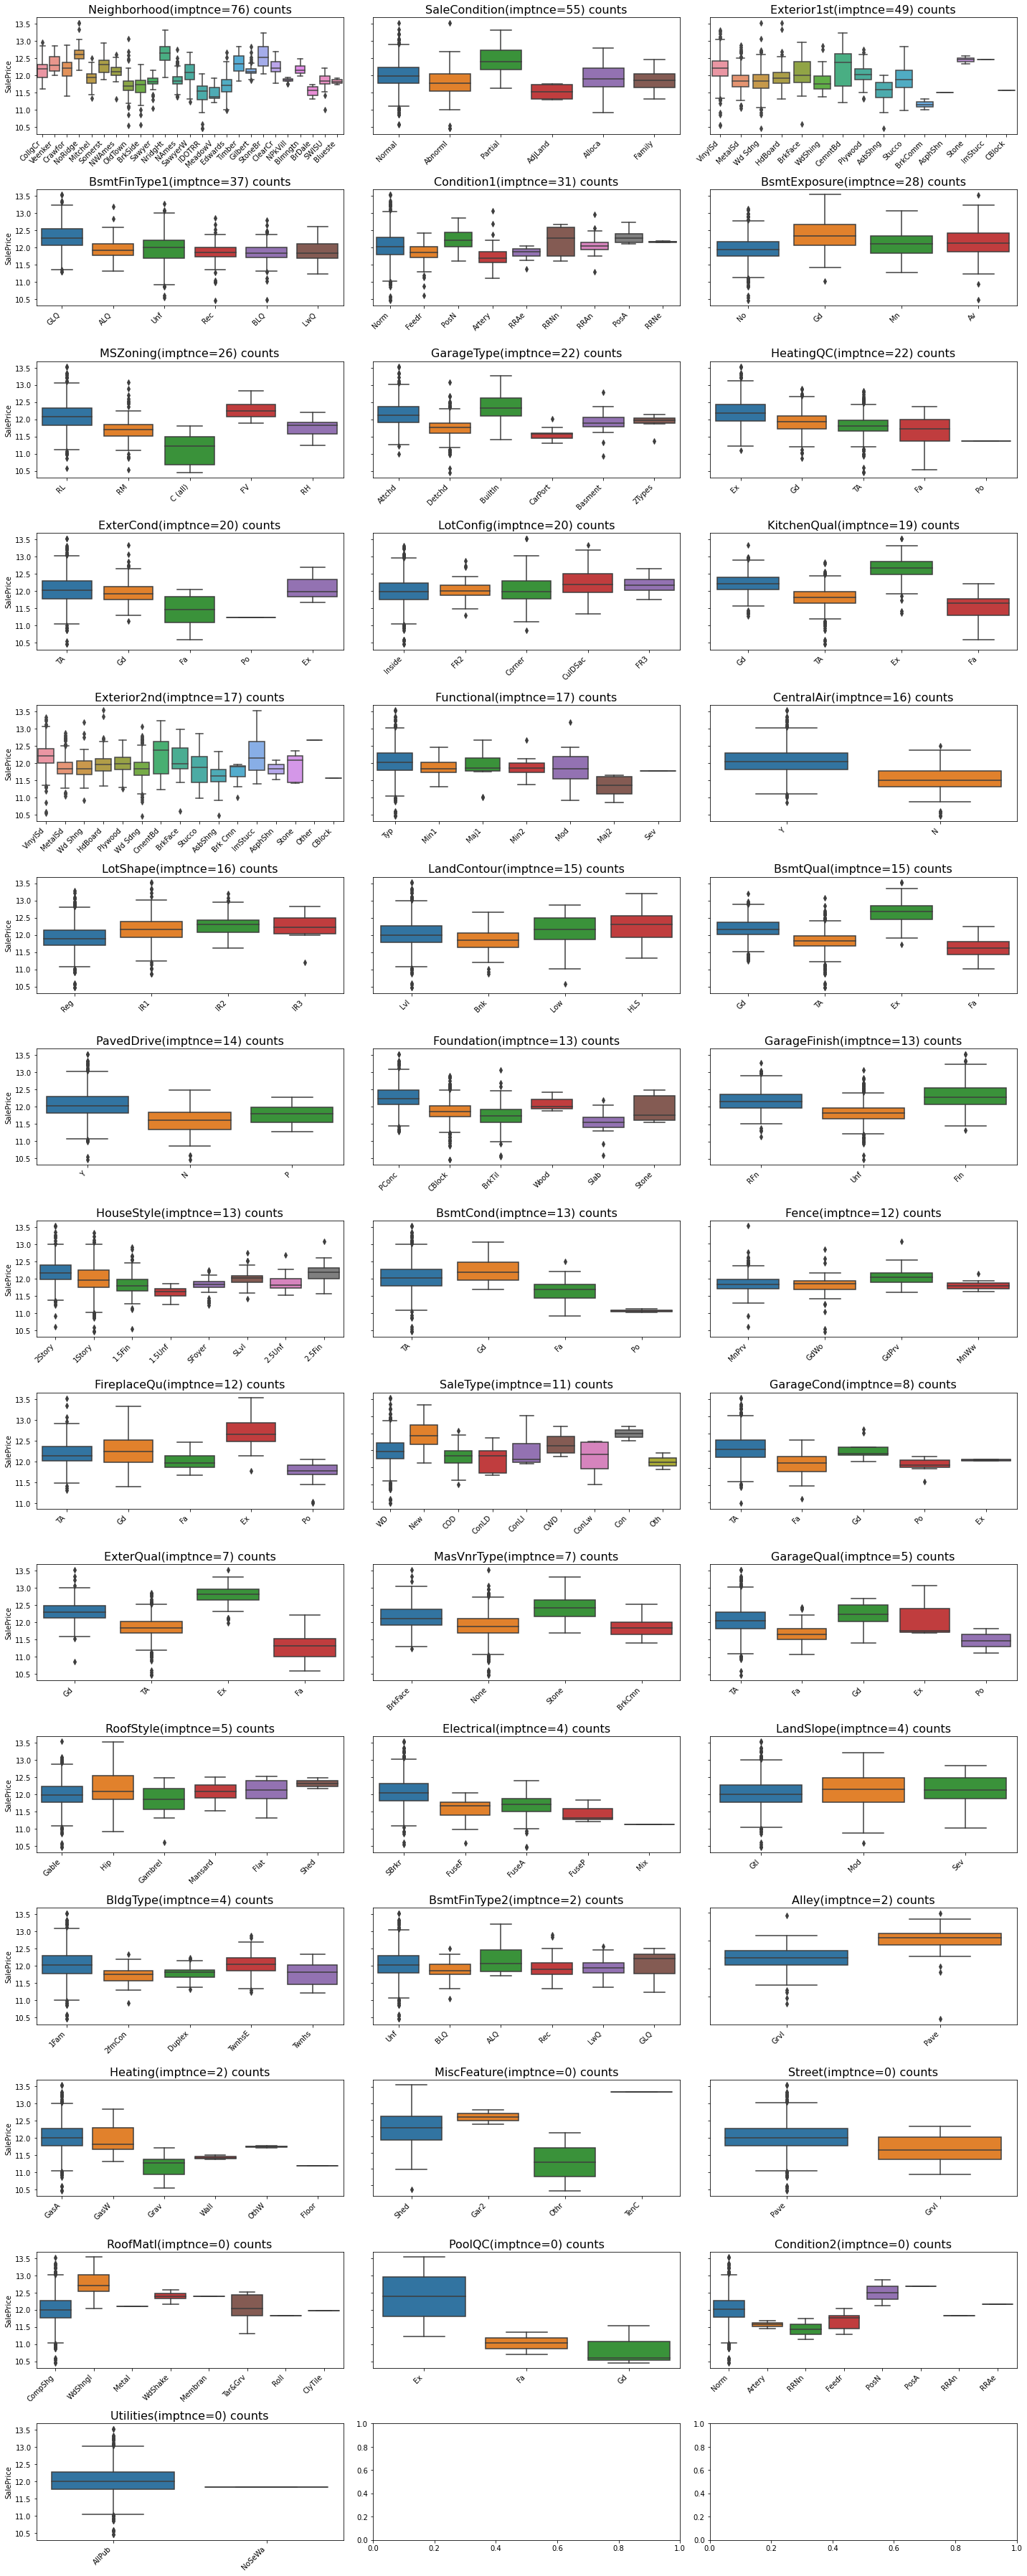

In [32]:
num_subplot_columns = 3
num_subplot_rows = len(top_cols)//num_subplot_columns + (1 if len(top_cols)%num_subplot_columns>0 else 0)
f, axes = plt.subplots(num_subplot_rows, num_subplot_columns, figsize=(20,50))

for index, field in enumerate(top_cols):
    row = index//num_subplot_columns
    column = index%num_subplot_columns
    current_axis=axes[row][column]
    
    sns.boxplot(x=field, y=target_variable, data=train_df, ax=current_axis)
    current_axis.set_title('{}(imptnce={}) counts'.format(field, feature_importances['importance'][field]), {'fontsize':16})
    current_axis.set_xticklabels(current_axis.get_xticklabels(), rotation=45, ha='right')
    current_axis.set_xlabel('')
    
    if column != 0: # Only show the y-axis labels and ticks on the left-most column!
        current_axis.set_ylabel('')
        current_axis.set_yticklabels('')
f.tight_layout()

# 3. Feature Engineering

## 3.1 Fill Missing Values

Comments on missing data:
* The fields with the highest number of missing data (**PoolQC**, **MiscFeature**, ..., **LotFrontage**) have a relatively low correlation with the target variable. It's safe to assume that they can be dropped.
* **Garage__ fields** in the list of missing data have the same amount of missing data. Suspicious. Anyway, we already have a garage-related input variable (**GarageCars**) which we identified to be highly-correlated with the target variable. Furthermore, we can see the Garage__ fields here are highly correlated with our chosen **GarageCars** field, i.e. it already encompasses the rest of them. Let's decide to drop them.
* Similar comment can be said about the **Bsmt__** fields. Drop!
* Next we have the **MasVnrArea**, **MasVnrType** which are related to the Masonry Veneer. We can see these fields are highly-correlated with **YearBuilt** and **OverallQual** which we assume to encompass the data from these masonry veneer fields. Let's decide to drop these.
* And finally, we have **Electrical** which has one missing instance. Let us decide to delete this instance/observation and keep the rest of the field.

In [31]:
# Drop the fields in missing_data EXCEPT for 'Electrical'
fields_to_drop = missing_data[missing_data['total_num']>1].index
train_df = train_df.drop(labels=fields_to_drop, axis=1)

index_to_drop = train_df.loc[train_df['Electrical'].isnull()].index
train_df = train_df.drop(index_to_drop)

NameError: name 'missing_data' is not defined

In [ ]:
#Check if there are still missing data...
missing_count = train_df.isnull().sum().max()
missing_count

# References
## Kernels
* [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by pmarcelino
* [House Prices: Comprehensive EDA & Visualization](https://www.kaggle.com/toyox2020/house-prices-comprehensive-eda-visualization) by toyox2020

## Data Science Articles
* [Is Normal Distribution Necessary in Regression? How to track and fix it?](https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd)
* [Multi-Collinearity in Regression](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)

## Statistics Articles
* [Q-Q Plot](https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm)

*END*

*HERE BEGINS THE "SCRATCH PAPER" CELLS USED FOR VARIOUS TESTING/POKING/API-RECALLING WHICH WERE INSTRUMENTAL FOR COMING UP WITH THE MORE CLEAN/FORMAL CONTENT ABOVE. KEPT HERE FOR REFERENCE.*

#### MSSubClass: type of dwelling
This column looks like a numerical variable at first glance, but it is actually number-coded categories.

In [ ]:
train_df['MSSubClass'].unique()

... and so we must treat them as categorical data!

In [ ]:
train_df['MSSubClass'] = pd.Categorical(train_df.MSSubClass)

In [ ]:
ax = sns.boxplot(x='MSSubClass', y='SalePrice', data=train_df)

Try plotting against SalePrice and LotArea?

In [ ]:
sns.scatterplot(data=train_df, x="SalePrice", y="LotArea")

In [ ]:
print(sns.__version__)